In [1]:
# 1. Build a logistic regression model
import pandas as pd
import numpy as np

data=pd.read_excel("Bupa1.xlsx")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Class   345 non-null    int64  
 1   F1      345 non-null    int64  
 2   F2      345 non-null    int64  
 3   F3      345 non-null    int64  
 4   F4      345 non-null    int64  
 5   F5      345 non-null    int64  
 6   F6      345 non-null    float64
dtypes: float64(1), int64(6)
memory usage: 19.0 KB


In [2]:
data.Class.value_counts()

1    200
0    145
Name: Class, dtype: int64

In [3]:
X_features=list(data.columns)
X_features.remove('Class')
X_features

['F1', 'F2', 'F3', 'F4', 'F5', 'F6']

In [4]:
import statsmodels.api as sm
Y=data.Class
X=data[['F1', 'F2', 'F3', 'F4', 'F5', 'F6']]
X=sm.add_constant(X)
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=42)

In [5]:
logit_model = sm.Logit(y_train, X_train)
logit_result = logit_model.fit()
print(logit_result.summary2())

Optimization terminated successfully.
         Current function value: 0.604710
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.111     
Dependent Variable: Class            AIC:              305.4700  
Date:               2023-10-16 15:39 BIC:              329.8636  
No. Observations:   241              Log-Likelihood:   -145.74   
Df Model:           6                LL-Null:          -163.88   
Df Residuals:       234              LLR p-value:      2.4233e-06
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const      5.5581     2.9953    1.8556   0.0635   -0.3126   11.4288
F1        -0.0634     0.0331   -1.9134   0.0557   -0.1284 

In [6]:
# 2.Find out which features are statistically significant in the logistic regression model built in Question 1. Build a new 
#logistic regression model using only the significant features.
def get_significant_vars( lm ):
    var_p_vals_df = pd.DataFrame( lm.pvalues )
    var_p_vals_df['vars'] = var_p_vals_df.index
    var_p_vals_df.columns = ['pvals', 'vars']
    return list( var_p_vals_df[var_p_vals_df.pvals <= 0.05]['vars'] )
significant_vars = get_significant_vars( logit_result )
significant_vars

['F3', 'F4', 'F5']

In [7]:
final_logit=sm.Logit(y_train,sm.add_constant(X_train[significant_vars])).fit()

Optimization terminated successfully.
         Current function value: 0.629920
         Iterations 6


In [65]:
print(final_logit.summary())


                           Logit Regression Results                           
Dep. Variable:                  Class   No. Observations:                  241
Model:                          Logit   Df Residuals:                      237
Method:                           MLE   Df Model:                            3
Date:                Tue, 26 Sep 2023   Pseudo R-squ.:                 0.07364
Time:                        00:19:40   Log-Likelihood:                -151.81
converged:                       True   LL-Null:                       -163.88
Covariance Type:            nonrobust   LLR p-value:                 2.339e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9591      0.415     -2.311      0.021      -1.772      -0.146
F3            -0.0483      0.013     -3.789      0.000      -0.073      -0.023
F4             0.0949      0.027      3.519      0.0

In [14]:
#F3 has negatively cofficient hence it is negatively effecting the probability (class) , F4 and F5 have positive cofficient hence
# they are positively effecting the probability (class)

In [8]:
#1.predict the probability of getting Class 
y_pred=pd.DataFrame({"actual":y_test,"predicted_prob":final_logit.predict(sm.add_constant(X_test[significant_vars]))})
y_pred.sample(10,random_state=42)

,actual,predicted_prob
57,1,0.602330
172,0,0.562213
322,1,0.999445
33,0,0.552867
101,1,0.617679
139,1,0.542205
254,0,0.623702
84,1,0.983597
311,0,0.894079
194,0,0.382265


In [9]:
y_pred['predicted']=y_pred.predicted_prob.map(lambda x:1 if x>0.5 else 0)
y_pred.sample(10,random_state=42)

,actual,predicted_prob,predicted
57,1,0.602330,1
172,0,0.562213,1
322,1,0.999445,1
33,0,0.552867,1
101,1,0.617679,1
139,1,0.542205,1
254,0,0.623702,1
84,1,0.983597,1
311,0,0.894079,1
194,0,0.382265,0


In [10]:
#4. Calculate Youden’s index for all possible cut-off probabilities ranging from 0.1 to 0.5 with an interval of0.01. Find the 
#optimal cut-off where Youden’s index is maximum.
cutoffs = np.arange(0.1, 0.5, 0.01)
optimal_cutoff = None
max_youden_index = -1

for cutoff in cutoffs:
    predicted_labels = (y_pred.predicted_prob >= cutoff).astype(int)

    true_positives = np.sum((y_pred.actual == 1) & (predicted_labels == 1))
    true_negatives = np.sum((y_pred.actual== 0) & (predicted_labels == 0))
    false_positives = np.sum((y_pred.actual == 0) & (predicted_labels == 1))
    false_negatives = np.sum((y_pred.actual== 1) & (predicted_labels == 0))

    sensitivity = true_positives / (true_positives + false_negatives)
    specificity = true_negatives / (true_negatives + false_positives)

    # Calculate Youden's Index
    youden_index = sensitivity + specificity - 1

    # Check if this cutoff yields a higher Youden's Index
    if youden_index > max_youden_index:
        max_youden_index = youden_index
        optimal_cutoff = cutoff

print("Optimal Cutoff Probability:", optimal_cutoff)
print("Maximum Youden's Index:", max_youden_index)

Optimal Cutoff Probability: 0.48999999999999977
Maximum Youden's Index: 0.3833333333333333


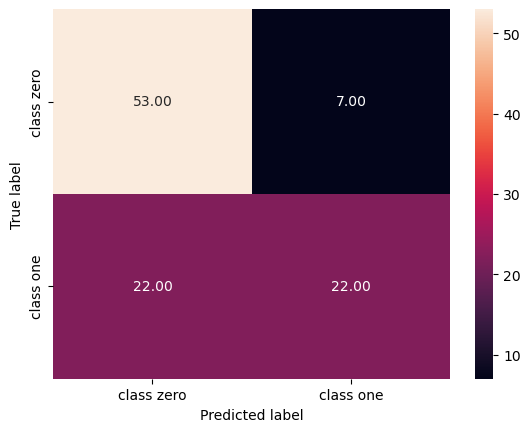

In [47]:
#5. Build a confusion matrix based on the cut-off probability found in Question 4 and report the precision and recall of the model
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import metrics
def draw_cm(actual,predicted):
    cm=metrics.confusion_matrix(actual,predicted,labels=[1,0])
    sn.heatmap(cm,annot=True,fmt='.2f' , xticklabels=["class zero","class one"],yticklabels=["class zero","class one"])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
y_pred['predicted_new']=y_pred.predicted_prob.map(lambda x: 1 if x>optimal_cutoff else 0)
draw_cm(y_pred.actual,y_pred.predicted_new)

In [11]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_pred['actual'], y_pred['predicted'])
recall = recall_score(y_pred['actual'], y_pred['predicted'])
print("\nPrecision:", precision)
print("Recall:", recall)


Precision: 0.7066666666666667
Recall: 0.8833333333333333


In [12]:
#6.Find optimal cut-off probability using cost-based approach using the cost of FPs and FNs as defined below.
#1. Cost of predicting “class” as “No class” (FNs) cases is 5 times more than predicting “No class” as “class” (FPs).
#2. Then find the precision and recall of the model for class= 1 
cost_fp = 1  
cost_fn = 5

cutoffs = np.arange(0.1, 0.5, 0.01)
optimal_cutoff = None
min_total_cost = float('inf')
for cutoff in cutoffs:
    y_pred['predicted'] = y_pred['predicted_prob'].map(lambda x: 1 if x > cutoff else 0)
    true_positives = np.sum((y_pred.actual == 1) & (predicted_labels == 1))
    true_negatives = np.sum((y_pred.actual== 0) & (predicted_labels == 0))
    false_positives = np.sum((y_pred.actual == 0) & (predicted_labels == 1))
    false_negatives = np.sum((y_pred.actual== 1) & (predicted_labels == 0))
    
    # Calculate the Optimal Cutoff Probability (Cost-based)
    total_cost = cost_fn * false_negatives + cost_fp * false_positives
    if total_cost < min_total_cost:
        min_total_cost = total_cost
        optimal_cutoff = cutoff

print("Optimal Cutoff Probability (Cost-based):", optimal_cutoff)

# Calculate precision and recall for class 1 using the chosen cutoff
y_pred['predicted_class_1'] = y_pred['predicted_prob'].map(lambda x: 1 if x > optimal_cutoff else 0)
precision_class_1 = precision_score(y_pred['actual'], y_pred['predicted_class_1'], pos_label=1)
recall_class_1 = recall_score(y_pred['actual'], y_pred['predicted_class_1'], pos_label=1)

print("Precision for Class 1:", precision_class_1)
print("Recall for Class 1:", recall_class_1)
    

Optimal Cutoff Probability (Cost-based): 0.1
Precision for Class 1: 0.5769230769230769
Recall for Class 1: 1.0


In [15]:
from sklearn.metrics import accuracy_score
accuracy_lr = accuracy_score(y_test, y_pred['predicted'])
print(accuracy_lr)


0.7211538461538461
